# Вводная информация

В этом проекте предполагается работа с датасетом из открытого источника.  
Потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

В ходе работы над проектом будут решены следующие задачи:  
1) Исследование датасета  
2) Предобработка данных  
3) Обучение модели  
4) Подготовка предсказания на тестовой выборке  
5) Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке  
6) Написание инструмента для тестирования  
7) Оформление документации  

Данные пациентов для предсказания риска сердечных приступов:  
1) id  - id  
2) Антропометрические параметры (вес, возраст, рост)  
3) Привычки (курение, качество сна и т.д)  
4) Давление  
5) Наличие хронических заболеваний  
6) Биохимия крови  
7) Таргет - высокий или низкий риск поражения сердца  


<b><i>Что имеем в таблице</i></b>  
<b>Высокая ценность для модели</b>:  
Age (возраст) – количество полных лет.  
Cholesterol (холестерин) – уровень общего холестерина в крови (ммоль/л или мг/дл).  
Heart rate (частота сердечных сокращений) – пульс в состоянии покоя (ударов в минуту).  
Diabetes (диабет) – наличие диагноза диабета (0 – нет, 1 – есть).  
Family History (наследственность) – наличие сердечно-сосудистых заболеваний у ближайших родственников (0/1).  
Smoking (курение) – факт курения (0 – не курит, 1 – курит).  
Obesity (ожирение) – наличие ожирения (0/1).  
Previous Heart Problems (анамнез сердечных проблем) – наличие ранее диагностированных сердечных заболеваний (0/1).  
Medication Use (приём лекарств) – факт приёма сердечно-сосудистых или сопутствующих препаратов (0/1).  
BMI (индекс массы тела) – показатель веса относительно роста.  
Triglycerides (триглицериды) – уровень триглицеридов в крови.  
Blood sugar (уровень сахара в крови) – показатель глюкозы (ммоль/л или мг/дл).  
Systolic blood pressure (систолическое давление) – верхнее значение артериального давления (мм рт. ст.).  
Diastolic blood pressure (диастолическое давление) – нижнее значение артериального давления (мм рт. ст.).  

<b>Средняя ценность для модели</b>:
Alcohol Consumption (употребление алкоголя) – частота или факт употребления алкоголя (0/1 или категориально).  
Exercise Hours Per Week (часы тренировок в неделю) – среднее количество часов физической активности за неделю.  
Diet (диета) – качество или тип питания (может быть категориально: сбалансированная/несбалансированная и т.д.).  
Stress Level (уровень стресса) – субъективная или измеренная оценка уровня стресса (шкала).  
Sedentary Hours Per Day (сидячие часы в день) – количество часов в день, проводимых в сидячем положении.  
Physical Activity Days Per Week (дни активности в неделю) – количество дней с умеренной или высокой физической активностью.  
Sleep Hours Per Day (часы сна в день) – среднее количество часов сна за сутки.  
Gender (пол) – 0 – женский, 1 – мужской (или наоборот).  

<b>Потенциально бесполезные признаки</b>:  
Income (доход) – уровень дохода, с одной точки зрения влияет на качество жизни, но с другой не влияет на состояние сердца. Оставим.  

<b>Признаки указывающие УЖЕ на проблемы с сердцем и могу дать утечку данных</b>:  
CK-MB – уровень изофермента креатинфосфокиназы MB, маркера повреждения сердца.  
Troponin (тропонин) – уровень тропонина, маркер повреждения миокарда.  

<b>Технические признаки</b>:  
id – идентификатор записи.  
Heart Attack Risk (Binary) (риск инфаркта, бинарно) – целевой признак: 0 – нет риска, 1 – есть риск.  

# Ипорты

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from config import DROP_COLS, OHE_COLS, ORD_COLS # type: ignore
from modeling.datapreprocessor import DataPreProcessor # type: ignore

# Классы и функции проекта

In [2]:

def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_categorical_columns(data, col=None, target=None):
    if col is None:
        categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    else:
        if isinstance(col, str):
            col = [col]
        elif not isinstance(col, (list, tuple, pd.Index)):
            print("Аргумент col должен быть None, строкой или списком.")
            return
        missing = [c for c in col if c not in data.columns]
        if missing:
            print(f"Столбцы {missing} не найдены в данных.")
            return
        categorical_columns = list(col)

    # Преобразуем в строки для корректной отрисовки
    data = data.copy()
    for c in categorical_columns:
        data[c] = data[c].astype(str)

    n = len(categorical_columns)
    ncols = 2
    nrows = (n * 2 + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axs = axs.flatten()

    index = 0
    colors = plt.cm.tab10.colors # type: ignore

    for c in categorical_columns:
        unique_values = data[c].value_counts().index
        color_map = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

        grouped_data = data[c].value_counts()
        axs[index].pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90,
                       colors=[color_map[val] for val in grouped_data.index])
        axs[index].set_title(f'{c} (общая)')
        axs[index].set_ylabel('')
        index += 1

        if target is not None and target in data.columns:
            grouped_data = data.groupby([target, c]).size().unstack(fill_value=0)
            grouped_data.plot(kind='bar', ax=axs[index],
                              color=[color_map[val] for val in grouped_data.columns])
        else:
            data[c].value_counts().plot(kind='bar', ax=axs[index],
                                        color=[color_map[val] for val in data[c].value_counts().index])

        axs[index].set_title(f'{c} (гистограмма)')
        axs[index].set_ylabel('Частота')
        index += 1

    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# пропуски
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)
    
def calc_target_correlations(df, target_col: str = None, drop_cols: list = None): # type: ignore
    """
    Считает корреляции признаков с таргетом, строит heatmap и рассчитывает VIF.
    Результаты выводятся прямо в Jupyter.
    """
    if drop_cols is None:
        drop_cols = []
    
    df_tmp = df.copy()

    # Преобразуем категориальные в числовые
    cat_cols = df_tmp.select_dtypes(include=["object", "category"]).columns
    for c in cat_cols:
        df_tmp[c] = df_tmp[c].astype("category").cat.codes

    # Числовые колонки
    numeric_cols = df_tmp.select_dtypes(exclude=["object", "category"]).columns.tolist()
    if target_col not in numeric_cols:
        raise ValueError(f"target_col '{target_col}' должен быть числовым")

    # Корреляции с target
    corr_df = (
        df_tmp[numeric_cols]
        .corr()[target_col]
        .drop(target_col)
        .sort_values(key=np.abs, ascending=False)
    )
    display("=== Корреляция с таргетом ===")
    display(corr_df)

    # Heatmap
    heatmap_cols = [col for col in numeric_cols if col not in drop_cols or col == target_col]
    corr_matrix = df_tmp[heatmap_cols].corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr_matrix, interpolation="nearest", cmap="coolwarm", aspect="auto")
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=8)
    plt.colorbar()
    plt.title("Correlation Heatmap (включая target)")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            value = corr_matrix.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=6, color="black")

    plt.tight_layout()
    plt.show()

    # VIF
    vif_cols = [col for col in numeric_cols if col != target_col and col not in drop_cols]
    X_vif = df_tmp[vif_cols].copy()
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_cols)

    vif_data = pd.DataFrame()
    vif_data["feature"] = vif_cols
    vif_data["VIF"] = [
        variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
    ]
    vif_data = vif_data.sort_values("VIF", ascending=False)

    display("\n=== VIF ===")
    display(vif_data)
    

# Исследование датасета

## Подгружаем базы

In [3]:
train_data = pd.read_csv('../data/raw/heart_train.csv')

## Общая статистика

In [4]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

In [5]:
cols_by_dtype = {dtype: train_data.select_dtypes(include=[dtype]).columns.tolist()
                 for dtype in train_data.dtypes.unique()}

for dtype, cols in cols_by_dtype.items():
    print(dtype, ":", cols)

int64 : ['Unnamed: 0', 'Diet', 'id']
float64 : ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure']
object : ['Gender']


In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8685.0,4342.000000,2507.287877,0.0,2171.000000,4342.000000,6513.000000,8684.0
Age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
Cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
Heart rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
Diabetes,8442.0,0.652097,0.476333,0.0,0.000000,1.000000,1.000000,1.0
Family History,8442.0,0.489576,0.499921,0.0,0.000000,0.000000,1.000000,1.0
Smoking,8442.0,0.902867,0.296157,0.0,1.000000,1.000000,1.000000,1.0
Obesity,8442.0,0.498342,0.500027,0.0,0.000000,0.000000,1.000000,1.0
Alcohol Consumption,8442.0,0.601990,0.489517,0.0,0.000000,1.000000,1.000000,1.0
Exercise Hours Per Week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0


## Пропуски

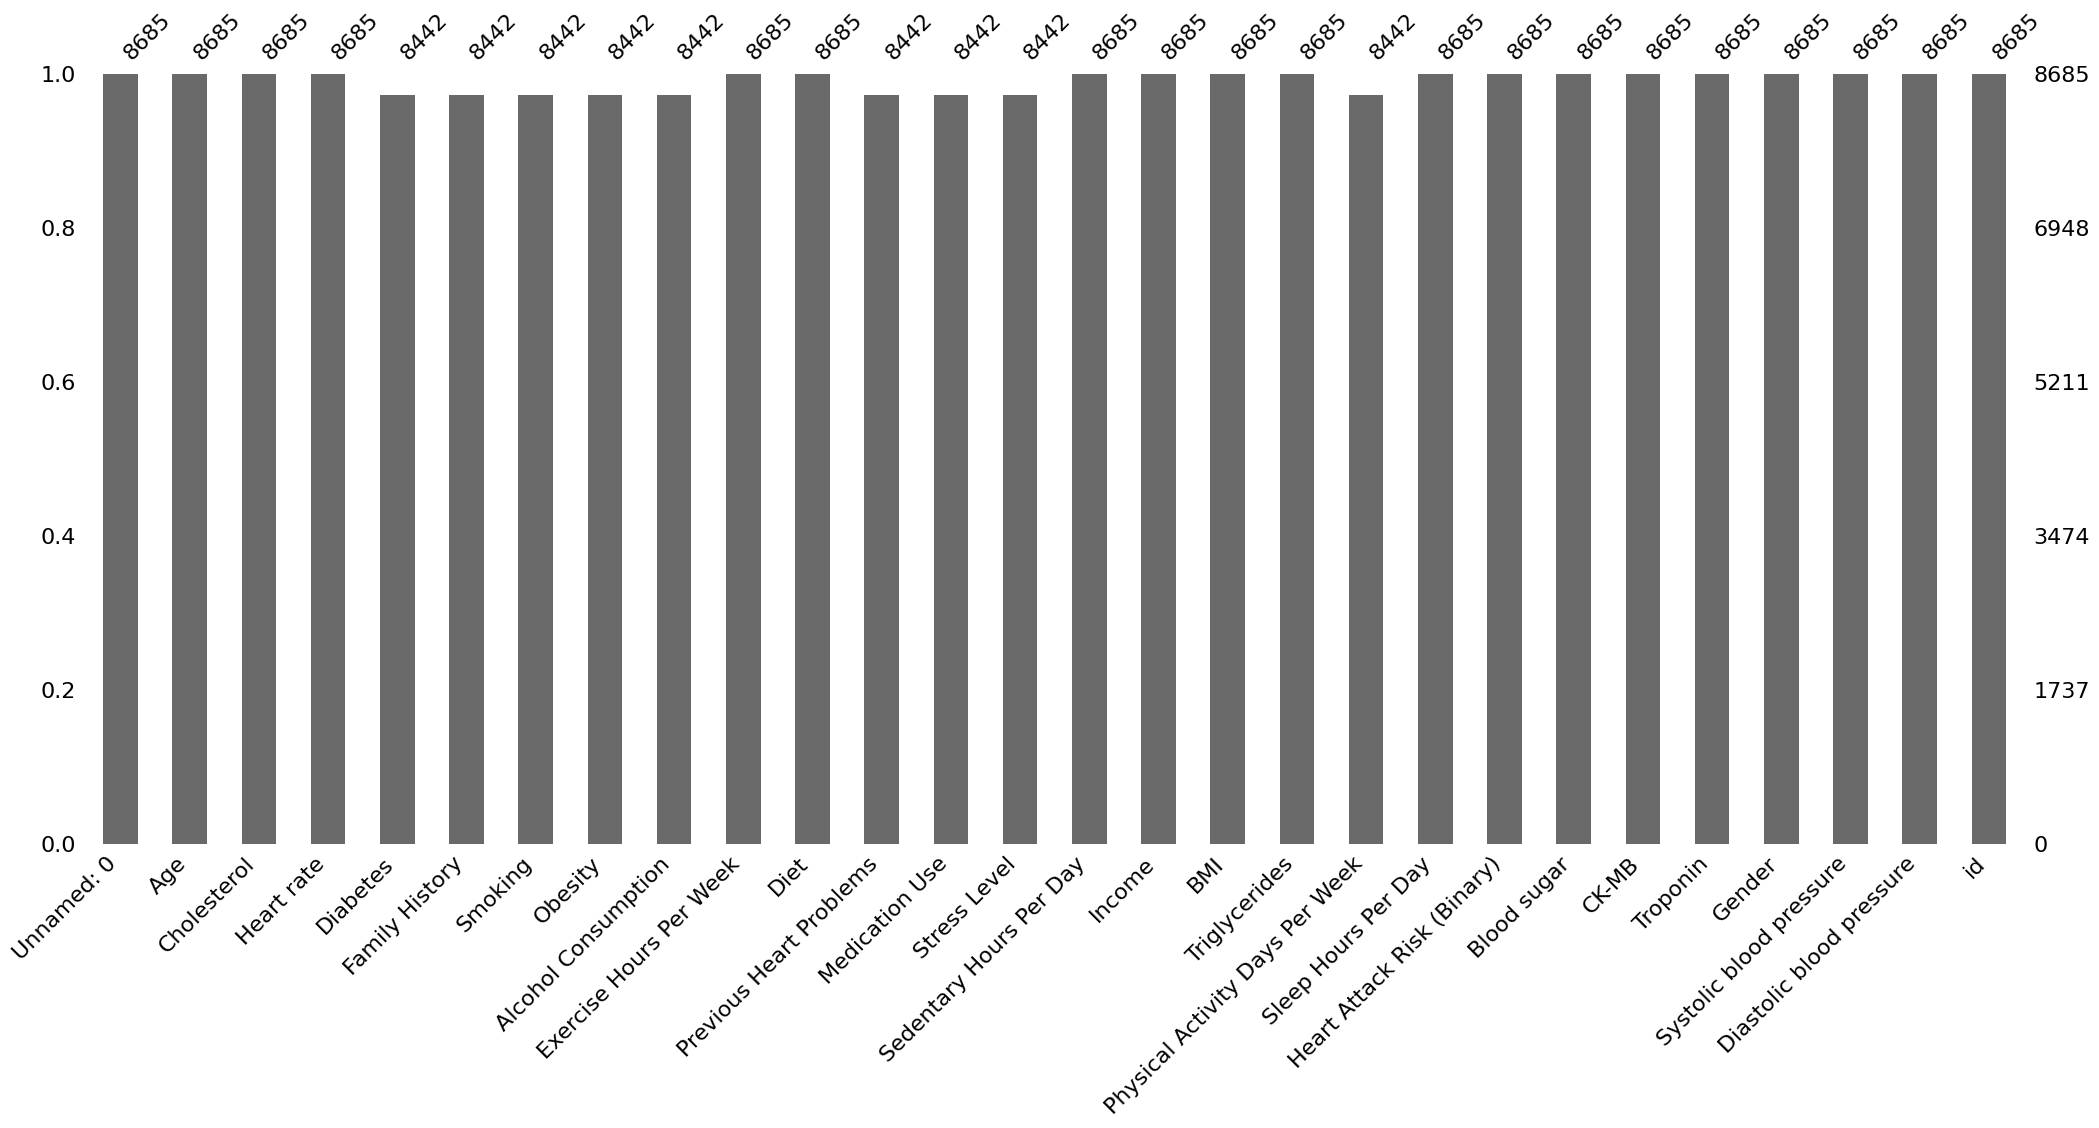

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

In [7]:
if train_data.isnull().sum().sum() > 0:
    msno.bar(train_data)
    plt.show()
    
    missing_data(train_data)

пропуски в части важных для модели признаков и части в бесполезных.

## Распределение числовых данных

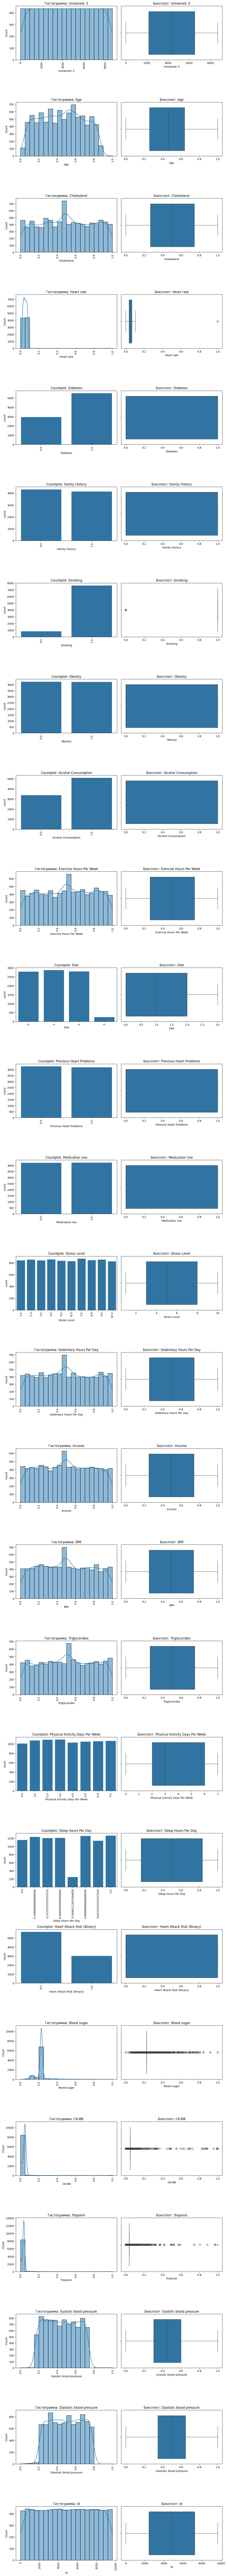

In [8]:
plot_combined(train_data, col=None, target=None, col_type=None, legend_loc='best')

CK-MB, Troponin - ненормальное распределение + мы их относим в опасным признакам и не будем использовать в обучении  
Heart rate, Smoking, Blood sugar - проверим по отдельности на выбросы

## Распределение категориальных данных

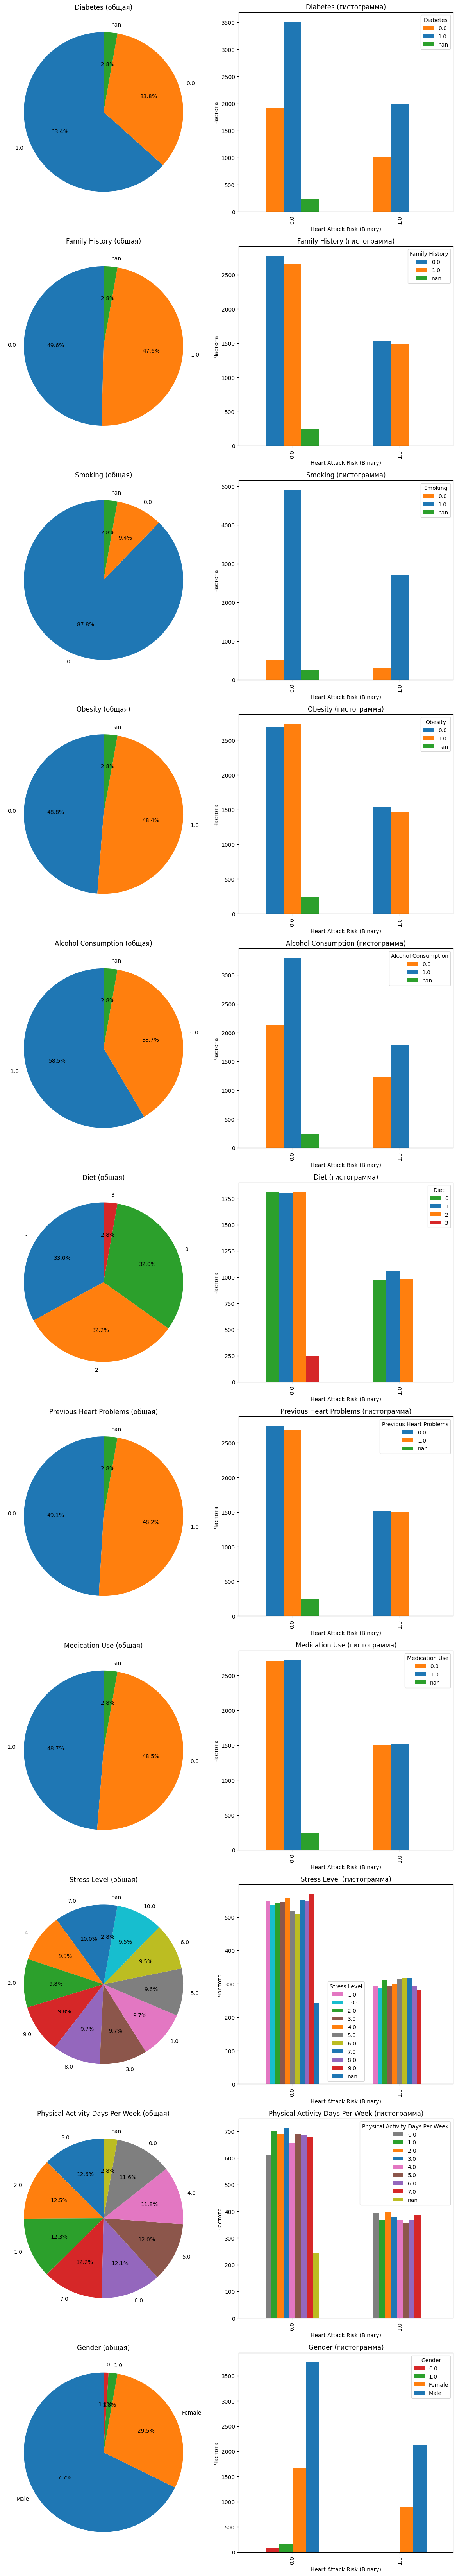

In [9]:
cat_cols = [
    "Diabetes",
    "Family History",
    "Smoking",
    "Obesity",
    "Alcohol Consumption",
    "Diet",
    "Previous Heart Problems",
    "Medication Use",
    "Stress Level",
    "Physical Activity Days Per Week",
    "Gender"
]

plot_categorical_columns(train_data, col=cat_cols, target="Heart Attack Risk (Binary)")

Типичный* портрет кандидата на инфаркат - курящий мужчина с диабетом и алкогольной зависимостью...  
Можно было бы и другие данные учесть, но опять же, они у нас вроде и категориальные, но нет.



*по предоставленным нам данным

In [10]:
train_data["Gender"].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

можно будет попробовать выровнять число мужчин/женщин, по идее даст более качественную модель, посмотрим по ходу дела...  
и учитывая равное число пропусков и часть гендера в виде 0/1 можно смело заявлять, чтобы было кривое объединение 2х баз данных - пропуски заменим на -1 (=unknown)  

In [11]:
train_data.sample(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
1061,1061,0.775281,0.092857,0.052246,0.0,1.0,1.0,1.0,1.0,0.050360,...,7.0,0.666667,1.0,0.227018,0.048229,0.036512,Male,0.735484,0.465116,5545
5877,5877,0.258427,0.414286,0.040330,1.0,0.0,0.0,1.0,0.0,0.157279,...,5.0,0.333333,1.0,0.223320,0.000944,0.000485,Female,0.509677,0.255814,572
2873,2873,0.516854,0.271429,0.042163,0.0,1.0,1.0,1.0,1.0,0.919129,...,2.0,0.166667,0.0,0.393281,0.003000,0.019614,Male,0.361290,0.488372,2039
4700,4700,0.629213,0.721429,0.048579,1.0,0.0,1.0,1.0,0.0,0.887152,...,2.0,0.333333,0.0,0.120553,0.005669,0.496068,Female,0.670968,0.744186,3671
1058,1058,0.752809,0.028571,0.078827,0.0,0.0,1.0,1.0,1.0,0.193036,...,5.0,0.833333,1.0,0.227018,0.048229,0.036512,Female,0.432258,0.651163,7422
4347,4347,0.258427,0.499780,0.042163,NaN,NaN,NaN,NaN,NaN,0.502110,...,NaN,0.504621,0.0,0.462451,0.032899,0.000194,1.0,0.483871,0.116279,9505
5854,5854,0.460674,0.860714,0.076077,0.0,0.0,1.0,1.0,0.0,0.513956,...,0.0,0.666667,0.0,0.227018,0.048229,0.036512,Female,0.464516,0.709302,8979
4504,4504,0.269663,0.499780,0.064161,NaN,NaN,NaN,NaN,NaN,0.502110,...,NaN,0.504621,0.0,0.166008,0.331151,0.000194,1.0,0.354839,0.302326,9410
7130,7130,0.325843,0.128571,0.054995,1.0,0.0,1.0,1.0,0.0,0.079990,...,7.0,0.166667,0.0,0.104743,0.007405,0.000583,Male,0.445161,0.593023,4390
5669,5669,0.213483,0.064286,0.064161,1.0,0.0,0.0,1.0,0.0,0.980953,...,1.0,0.333333,0.0,0.029644,0.001642,0.000291,Female,0.722581,0.279070,1070


## Выводы/план предобработки

Судя по примерам в выводе - данные уже почти все нормализованны.  
Что надо сделать:  
1) Heart rate, Smoking, Blood sugar - проверим по отдельности на выбросы и удалим выбросы;  
2) Удалить непонятный столбец, дублирующий номер строки;  
3) Названия столбцов привести к строчным буквам, пробелы заменить на нижнее подчеркивание;  
4) Заменить пропуски на -1, что будет считать как Unknown - сердце это не шутки, мы не можем себе позволить заполнять пропуски средними/медианами, но и удалять выборку тоже не стоит;  
5) Закодировать признаки в OneHotEncoder - gender;  
6) Удалить дубликаты;  

Сделать новые фичи:  
pulse_pressure = systolic_blood_pressure − diastolic_blood_pressure  
Разница между верхним и нижним давлением. В медицине отражает эластичность сосудов. Большое значение связано с повышенным риском сердечно-сосудистых проблем.  
  
bp_ratio = systolic_blood_pressure / diastolic_blood_pressure  
Отношение верхнего к нижнему давлению. Может указывать на проблемы с сопротивлением сосудов и сердечный выброс.  
  
chol_trig_ratio = cholesterol / triglycerides  
Соотношение холестерина к триглицеридам. Используется в оценке липидного обмена и риска атеросклероза.  
  
obesity_exercise_interaction = obesity × exercise_hours_per_week  
Показывает, компенсирует ли физическая активность лишний вес. Низкое значение при ожирении — индикатор риска.  
  
age_smoking_interaction = age × smoking  
Учитывает совокупный эффект возраста и курения. Стаж курения и возраст усиливают риск хронических заболеваний.  
  
stress_sedentary_ratio = stress_level / (sedentary_hours_per_day + 1)  
Отношение стресса к времени сидячей активности. Высокий стресс при низкой подвижности часто связан с ухудшением здоровья.  
  
bp_mean = (systolic_blood_pressure + diastolic_blood_pressure) / 2  
Среднее артериальное давление. Один из базовых индикаторов состояния сердечно-сосудистой системы.  

# Предобработка данных

In [12]:
train_data['Heart rate'].describe().T

count    8685.000000
mean        0.050658
std         0.023453
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         1.000000
Name: Heart rate, dtype: float64

Явно, что-то не так с данными, когда до 75% это 0.06, а дальше резко в 1  
Оставим только то, что меньше 1

In [13]:
train_data = train_data[train_data['Heart rate'] < 1]
train_data['Heart rate'].describe().T

count    8683.000000
mean        0.050439
std         0.018507
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         0.105408
Name: Heart rate, dtype: float64

In [14]:
train_data['Smoking'].describe().T

count    8442.000000
mean        0.902867
std         0.296157
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Smoking, dtype: float64

Тут все "нормально", просто очень много курильщиков

In [15]:
train_data['Blood sugar'].describe().T

count    8683.000000
mean        0.227357
std         0.076630
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: Blood sugar, dtype: float64

In [16]:
train_data[train_data['Blood sugar'] > 0.8]

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
101,101,0.573034,0.796429,0.044913,1.0,0.0,1.0,0.0,1.0,0.827922,...,7.0,0.333333,0.0,0.806324,0.000080,0.000388,Male,0.658065,0.639535,5739
2730,2730,0.629213,0.517857,0.036664,1.0,0.0,1.0,0.0,1.0,0.585140,...,5.0,0.500000,0.0,0.918972,0.016381,0.009127,Male,0.258065,0.511628,1209
3043,3043,0.449438,0.939286,0.034830,0.0,0.0,1.0,1.0,1.0,0.316401,...,5.0,0.166667,0.0,0.806324,0.018283,0.034761,Male,0.167742,0.500000,2987
3659,3659,0.449438,0.871429,0.034830,1.0,1.0,1.0,0.0,0.0,0.425117,...,7.0,0.166667,0.0,0.806324,0.018283,0.034761,Male,0.225806,0.337209,2985
4167,4167,0.516854,0.346429,0.052246,0.0,0.0,1.0,1.0,0.0,0.221570,...,2.0,1.000000,0.0,0.843874,0.006070,0.129042,Male,0.709677,0.593023,7149
4305,4305,0.629213,0.396429,0.076077,0.0,0.0,1.0,0.0,1.0,0.678982,...,7.0,0.333333,1.0,1.000000,0.001148,0.001262,Male,0.593548,0.395349,7630
4964,4964,0.550562,0.925000,0.046746,1.0,0.0,1.0,0.0,1.0,0.414802,...,6.0,0.166667,1.0,0.843874,0.007405,0.001165,Male,0.632258,0.790698,234
5008,5008,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,...,6.0,0.833333,0.0,0.918972,0.003901,0.001748,Male,0.561290,0.511628,5194
5182,5182,0.629213,0.517857,0.036664,0.0,1.0,1.0,0.0,1.0,0.892805,...,4.0,0.666667,1.0,0.918972,0.016381,0.009127,Male,0.296774,0.767442,1207
5590,5590,0.168539,0.339286,0.080660,1.0,0.0,1.0,0.0,0.0,0.128648,...,6.0,1.000000,1.0,1.000000,0.003934,0.008545,Male,0.193548,0.372093,8859


В целом, значений много и в таком виде выглядит все допустимо. Тут оставим как есть, за не имением большей информации об исходных данных

In [17]:
preprocessor_train = DataPreProcessor(
    drop_cols=DROP_COLS,
    ohe_cols=OHE_COLS,
    ord_cols=ORD_COLS,
    name='train'
)
train_data_processed = preprocessor_train.fit_transform(train_data)

In [18]:
display(train_data_processed)

,gender_male,diet,stress_level,physical_activity_days_per_week,age,cholesterol,heart_rate,diabetes,family_history,smoking,...,systolic_blood_pressure,diastolic_blood_pressure,pulse_pressure,bp_ratio,chol_trig_ratio,obesity_exercise_interaction,age_smoking_interaction,stress_sedentary_ratio,bp_mean,heart_attack_risk_(binary)
0,1.0,0.333333,0.8,0.500,0.359551,0.732143,0.704348,1.0,1.0,1.0,...,0.212903,0.709302,0.103430,8.947024e-07,8.021070e-07,0.690790,0.733333,0.674408,0.424284,0.0
1,0.0,0.666667,0.9,0.500,0.202247,0.325000,0.452174,1.0,1.0,0.5,...,0.412903,0.569767,0.367460,2.160122e-06,6.762391e-07,0.334279,0.539394,0.716624,0.456582,0.0
2,0.0,0.666667,0.6,0.375,0.606742,0.860714,0.530435,1.0,0.5,1.0,...,0.238710,0.220930,0.503267,3.220633e-06,7.109414e-05,0.962746,0.866667,0.425383,0.177199,0.0
3,0.0,0.000000,0.3,0.125,0.730337,0.007143,0.504348,0.5,0.5,1.0,...,0.348387,0.267442,0.552386,3.882929e-06,5.841919e-08,0.334279,0.933333,0.273821,0.260629,1.0
4,1.0,0.333333,0.8,0.750,0.775281,0.757143,0.208696,0.5,0.5,1.0,...,0.619355,0.441860,0.627465,4.178128e-06,1.158207e-05,0.334279,0.957576,0.554445,0.498537,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,1.0,0.666667,0.6,0.125,0.359551,0.357143,0.382609,1.0,0.5,1.0,...,0.632258,0.511628,0.583246,3.683559e-06,1.725250e-06,0.951203,0.733333,0.537266,0.542697,0.0
8681,1.0,0.666667,0.8,0.875,0.516854,0.832143,0.347826,1.0,1.0,1.0,...,0.561290,0.511628,0.528060,3.270099e-06,2.253747e-06,0.637575,0.818182,0.754724,0.504789,0.0
8682,1.0,0.666667,1.0,0.250,0.471910,0.067857,0.226087,1.0,0.5,1.0,...,0.374194,0.558140,0.346401,1.998394e-06,3.839270e-07,0.334279,0.793939,0.531927,0.429693,0.0
8683,1.0,0.666667,0.9,0.625,0.595506,0.000000,0.713043,0.5,1.0,1.0,...,0.477419,0.744186,0.281997,1.912257e-06,0.000000e+00,0.334279,0.860606,0.511022,0.584212,0.0


'=== Корреляция с таргетом ==='

smoking                            0.086421
diabetes                           0.075555
age_smoking_interaction            0.067706
family_history                     0.057364
previous_heart_problems            0.056432
medication_use                     0.055508
alcohol_consumption                0.046288
diet                              -0.043787
obesity                            0.041623
stress_sedentary_ratio             0.035268
systolic_blood_pressure            0.033803
obesity_exercise_interaction       0.032755
stress_level                       0.032025
bp_mean                            0.031703
physical_activity_days_per_week    0.026715
sleep_hours_per_day               -0.019488
cholesterol                        0.018920
pulse_pressure                     0.015538
diastolic_blood_pressure           0.012084
triglycerides                      0.012062
heart_rate                        -0.011109
exercise_hours_per_week            0.009487
gender_male                     

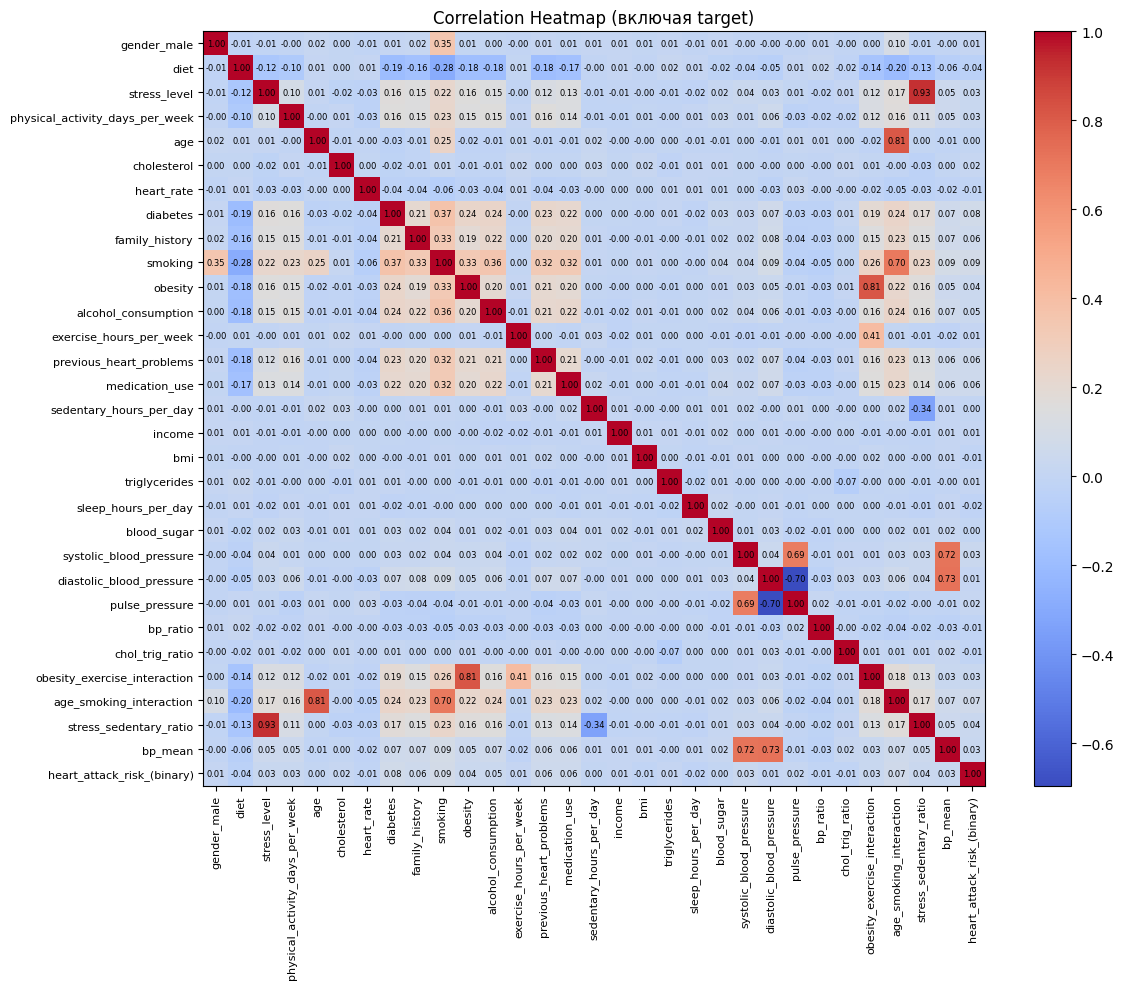

/home/root6/python/virtual_env/practicum/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


'\n=== VIF ==='

,feature,VIF
29,bp_mean,inf
21,systolic_blood_pressure,inf
22,diastolic_blood_pressure,inf
23,pulse_pressure,inf
28,stress_sedentary_ratio,28.756338
2,stress_level,24.859345
27,age_smoking_interaction,16.652577
4,age,9.369914
26,obesity_exercise_interaction,5.777854
9,smoking,5.461645


In [19]:
# и посмотреть на зависимости признаков
corr = calc_target_correlations(train_data_processed, target_col="heart_attack_risk_(binary)")

новые признаки показали плохие значения  
20	diastolic_blood_pressure	inf  
21	pulse_pressure	inf  
26	bp_mean	inf  
19	systolic_blood_pressure	inf  
25	age_smoking_interaction	16.628150  

лучше уберем  
подозреваю, если бы были сырые данные, не нормализованные - ситуация была бы лучше, но имеем, что имемм...

## Выводы

До ввода новых фич:  
Сильной кореляции между таргетом и признаками не наблюдается  
В целом, по базе, есть явная зависимость - взрослые мужчины курят  
Мультиколлинеарность также не наблюдается

После:  
Характерны чрезмерные показатели мультиколлинеарности которые необходимо исключать при "обычном обучении"  
Здесь будет использоваться проверка значимости SHAP + SelectKBest, что должно автоматически отсечь мусорные признаки  
Проведем серию тестов, как без новых фич, так и с ними, без удаления перекоса и с очисткой.

# Результаты тестирования

## Вводная

Использовался XGBClassifier  
С помощью optuna были подобраны наилучшие гиперпараметры, в том числе набор фич которые сильнее всего влияют на качество модели  
Была использована сетка параметров для подбора пороговых значений FN/FP/Recail  

## Тесты до объединения признаков

### ballance accuracy метрика:

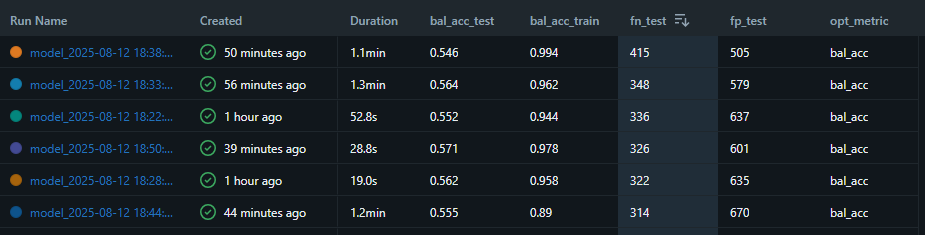

1) Большие показатели FN на тестовой выборке;  
2) Скор на тренировочной выборке слишком высокий, что говорит о переобучении модели;  
3) На тестовой выборки скор слишком низкий для медицинской модели.

### f2 метрика:

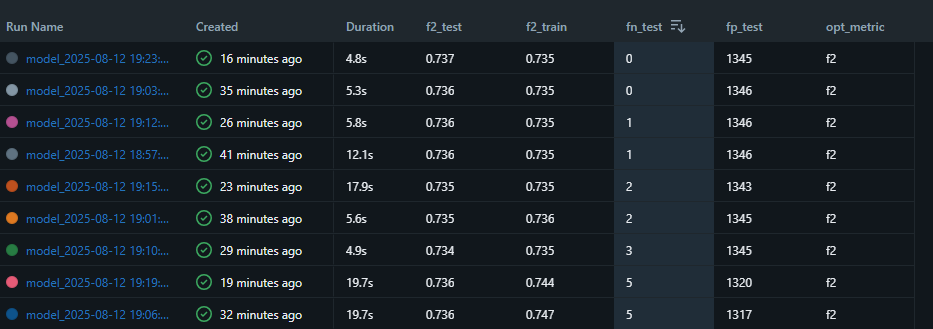

1) Показатели FN уже приемлимые;  
2) Скор на тренировочной выборке адекватный;  
3) На тестовой выборке скор также неплох.

## Тесты после объединения признаков

### ballance accuracy метрика:

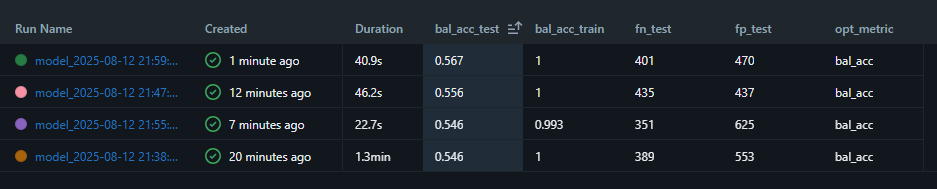

А здесь стало еще хуже относительно первых тестов  
Так еще появились признаки мультиколлинеарности:  
1) pulse_pressure - bp_ratio: 0.901  
2) stress_level - stress_sedentary_ratio: 0.929  

### f2 метрика:

Метрика почти такая же, но есть незначительные улучшения в плане FP, но совсем как погрешность...

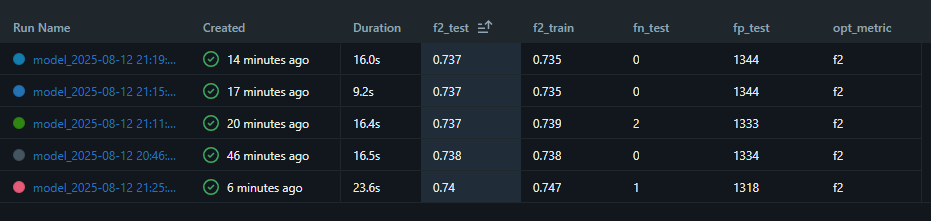

## Тесты с удалением признаков которые согласно VIF имеют высокие показатели > 10

Т.к. ballance accuracy показал себя хуже в прошлых тестах, его больше брать не будем, остановимся только на F2  
Также категориальные признаки обработаны с помощью ordinal encoding (несмотря на то, что они численные у нас, в реальности, скорее всего там нормальные категории)  
Дополнительно убрал признак diabetes т.к. он дает большой перекос значимости по SHAP  
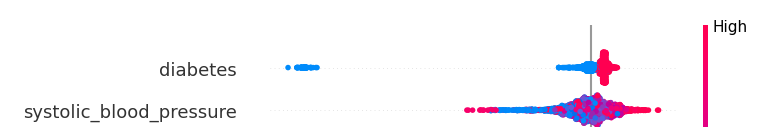  
family_history ведет себя аналогично, убираем  
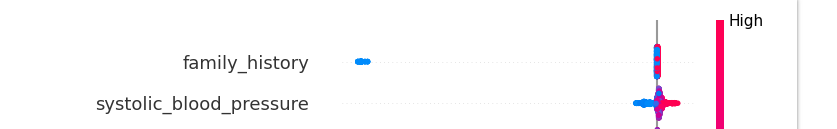

Более лучших реузльтатов не дало  
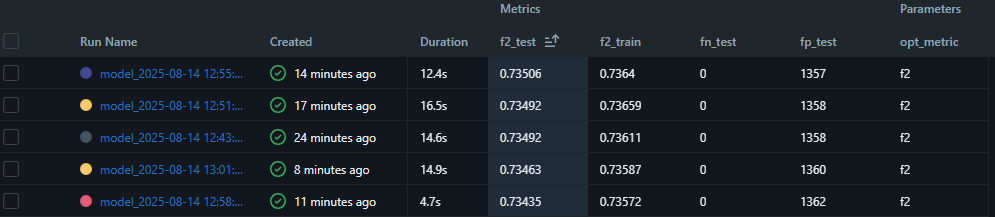

Также был проверен under/over sampling  
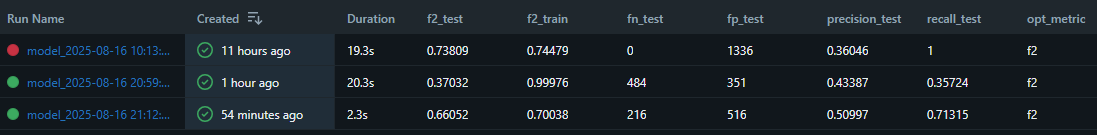  
1) scale_pos_weight для xgboost с перебором в optuna  
2) undersampling  
3) oversampling  


Результат хуже

## Выводы

В итоге F2 показывает себя лучше на новом наборе фич, без удаления признаков сильно перекашивающих в SHAP.  
На этом тесты закончим, т.к. на текущем нормализованном наборе данных они в большей степени бесполезны, вся разница на уровне погрешности.  
Обучим модель с лучшей метрикой/параметрами с нуля и перейдем к приложению.

# Результаты обучения модели

В ходе работы модель была обучена множество раз для подбора наилучших параметров, гиперпараметров, набора признаков и т.д.

## Входные параметры

Параметры, которые были выявлена как наилучшие*  
`* подразумевается FN = 0, FP -> 0

В результате исследований модель показала наилучшие результаты со следующими настройками

Параметры:  
  "TEST_SIZE": 0.25,  
  "RANDOM_STATE": 40,  
  "N_TRIALS": 300,  
  "N_SPLITS": 5,  
  "METRIC": "f2",  
  "TARGET_COL": "heart_attack_risk_(binary)",  
  "FN_PENALTY_WEIGHT": 0.5,  
  "FP_PENALTY_WEIGHT": 0.5,  
  "MIN_PRECISION": 0.81,  
  "FN_STOP": 1,  
  "MAX_FN_SOFT": 1,  
  "BETA": 2  

Гиперпараметры:  
  "n_estimators": 200,  
  "max_depth": 11,  
  "learning_rate": 0.021505166617658802,  
  "subsample": 0.9068199839118195,  
  "colsample_bytree": 0.6760003732610677,  
  "gamma": 4.905507456668351,  
  "min_child_weight": 10,  
  "scale_pos_weight": 9.560568223964832  

Также модель показала следующие результаты работы:  

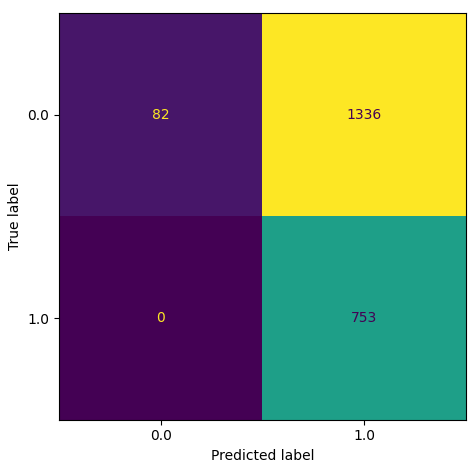  

Мы точно не пропускаем больных, но у нас значительный уровень ложнобольных  
Но лучше мы перепроверим, чем упустим...

In [20]:
preprocessor_train = DataPreProcessor(
    drop_cols=DROP_COLS,
    ohe_cols=OHE_COLS,
    ord_cols=ORD_COLS,
    name="train"
)
train_data_processed = preprocessor_train.fit_transform(train_data)

Наиболее значимые признаки, которые влияют на предсказания  
Красный дает риск инфаркта, синий же наоборот - этот риск уменьшает  

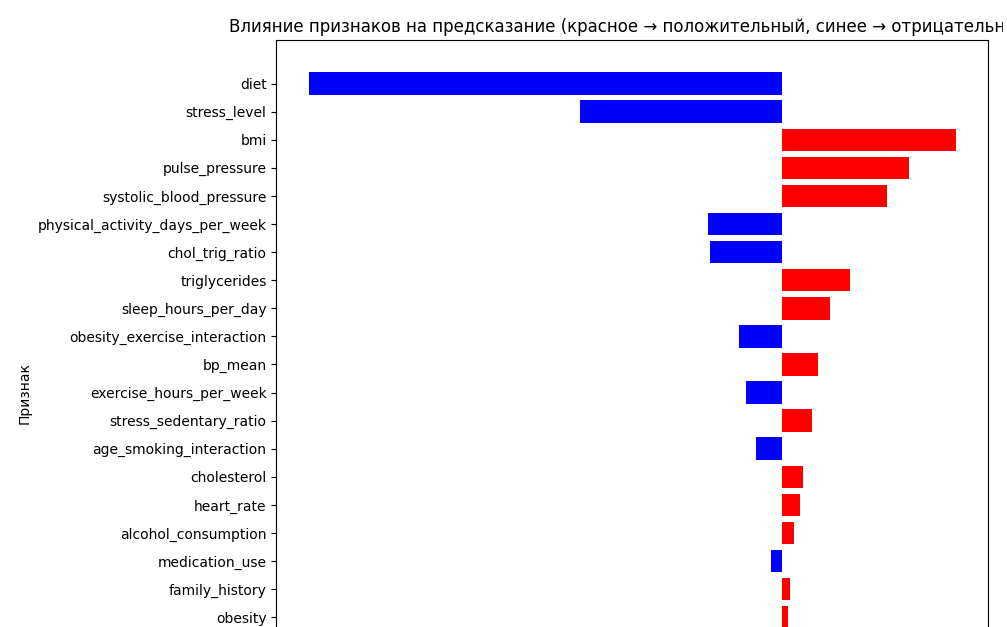

# Выводы

Ранее был составлен типичный портрет кандидата на инфаркт - курящий мужчина с диабетом и алкогольной зависимостью.  
Как мы видим выше, на деле оказалось все совсем не так - модель говорит, что это те кто на диете, с высоким уровнем стресса, высоким давлением и высокими физическим нагрузками и т.д.